# Recommend RBS sequences - Escherichia coli

This notebook shows the online recommendation of RBS sequences with the goal of achieving a high protein expression level.

There are several parts of the implementation. 

- Reading the dataset
- Embedding
    - Label
    - One-hot embedding
    - K-mer 
    - PMW (to be added)
    - Unsupervised (to be added)
- Kernels
    - Spectrum
    - Mixed Spectrum
    - Weighted Degree
    - Weighted Degree with Shifting
- Create reward environment
- Apply bandits algorithms
    - GPUCB

## Some open questions

- How to define arms? In this notebook, we consider an RBS sequence is an arm, where arms are dependent (we assume similar sequences having similar protein expression levels). Are there any other ways to define arms? For example, how about define arms as different experts, where each expert recommends one arm.

- How to recommend multiple arms once?

- How to select embedding methods? How to evaluate them?

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels import spectrum_kernel
from codes.kernels_pairwise import spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading the Dataset

In [3]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

Path = '../data/RBS_list.xlsx'

df = pd.read_excel(Path, sheet_name='Unique RBS')
df.columns = ['A', 'B', 'C', 'D', 'E', 'F']
df.head()

,A,B,C,D,E,F
0,ACGATCTTAAGTAAGCGGGGAAAATAATG,AAGTAAGCGGGGA,57706.0,NaN,AAGTAAGCGGGGA,57706.0
1,ACGATCTTAAGTAGACGCGGAAAATAATG,AAGTAGACGCGGA,613.0,NaN,AAGTAGACGCGGA,613.0
2,ACGATCTTAAGTAAGCGCGGAAAATAATG,AAGTAAGCGCGGA,5313.0,NaN,AAGTAAGCGCGGA,5313.0
3,ACGATCTTAAGTAAACGAGGAAAATAATG,AAGTAAACGAGGA,19594.0,NaN,AAGTAAACGAGGA,19594.0
4,ACGATCTTAAGTAGGCGAGGAAAATAATG,AAGTAGGCGAGGA,33626.0,NaN,AAGTAGGCGAGGA,33626.0


In [4]:
df = df.drop_duplicates(subset =['B', 'C'])

new_df = df[['B', 'C']].dropna()
# mean normalization 
# new_df['normalized_F'] = (new_df['F'] - new_df['F'].mean())/new_df['F'].std()
# min-max normalization
new_df['normalized_C'] = (new_df['C'] - new_df['C'].min())/(new_df['C'].max() - new_df['C'].min())
data = np.asarray(new_df[['B', 'normalized_C']])
data.shape

(113, 2)

## Embedding & Create Rewards Environment

In [5]:
my_env = Rewards_env(data, 'label')

## Recommendations with GPUCB

In [6]:
num_rounds = 100
num_exper = 10
init_per = 0.2

sds = defaultdict(list)
rs = defaultdict(list)

IntProgress(value=0, description='Running', max=10)

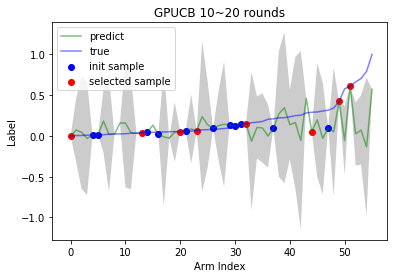

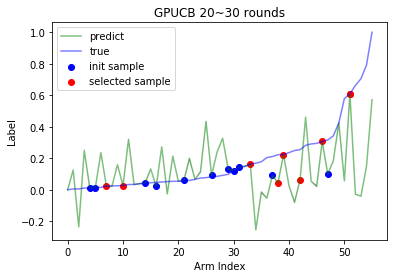

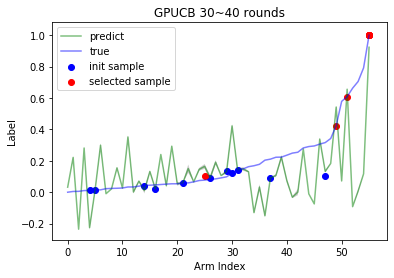

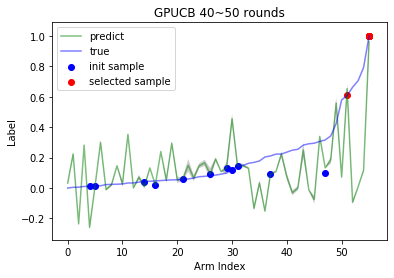

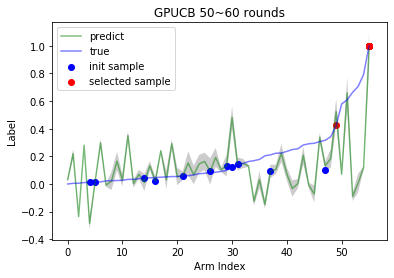

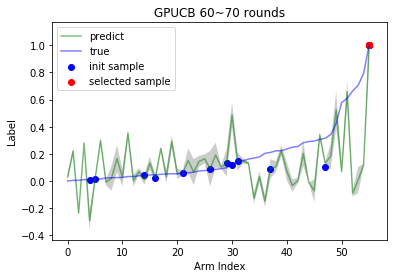

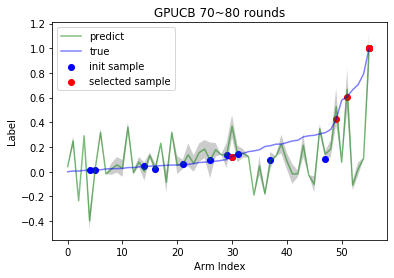

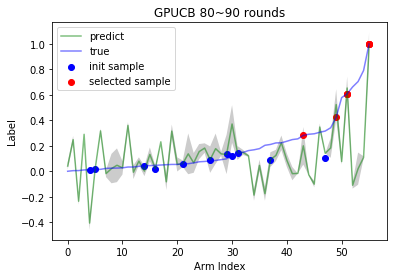

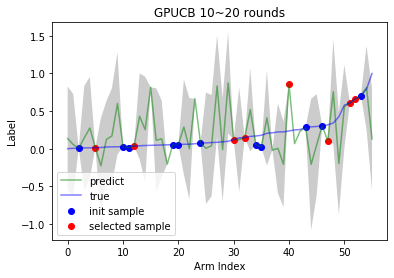

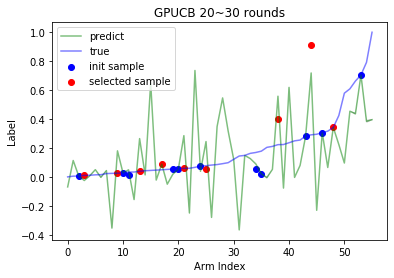

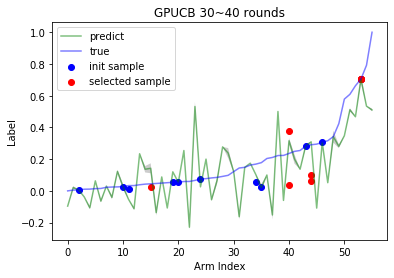

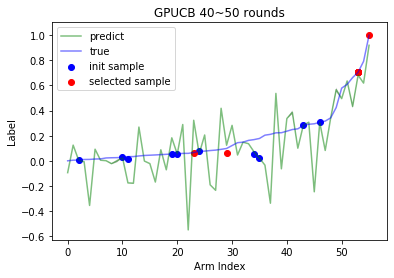

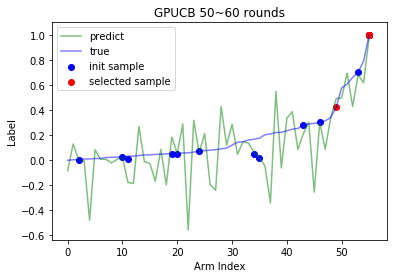

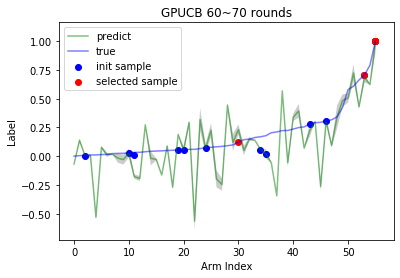

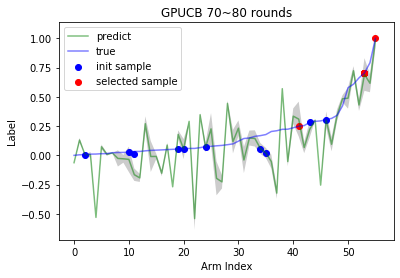

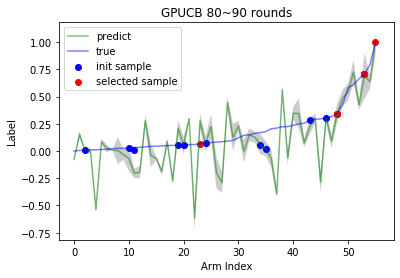

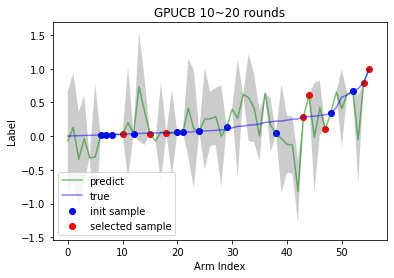

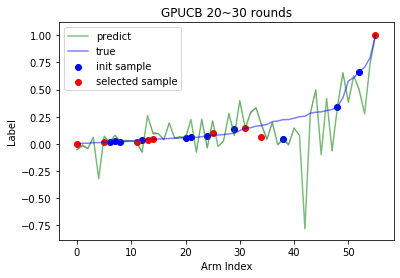

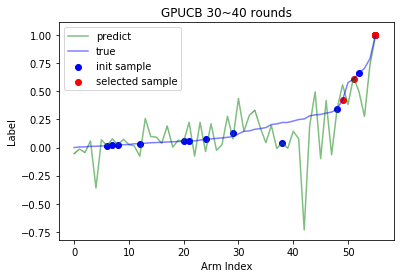

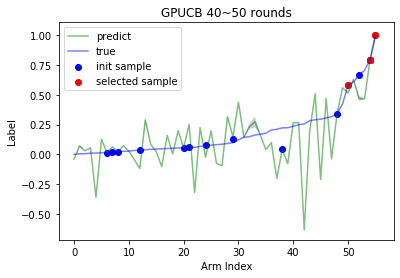

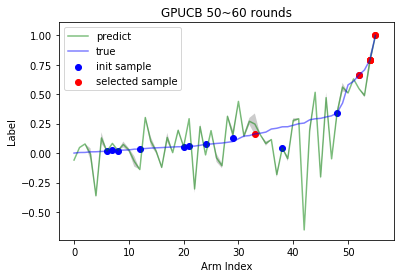

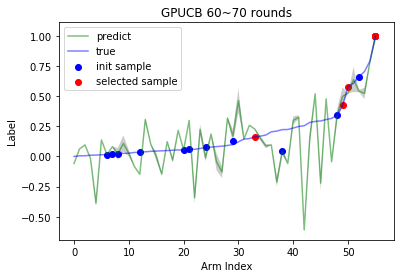

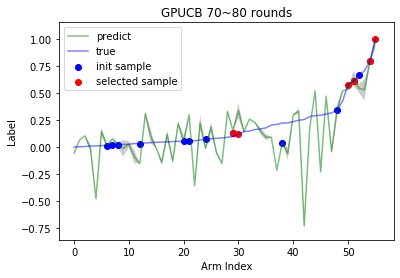

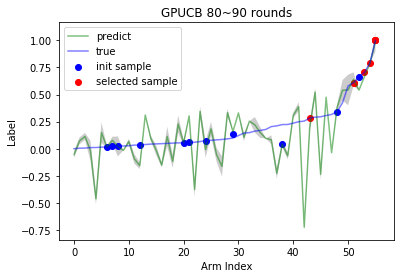

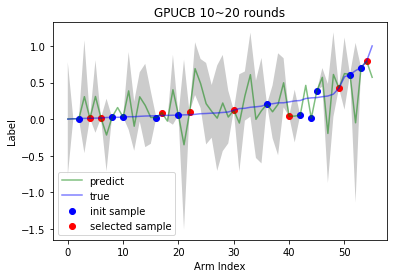

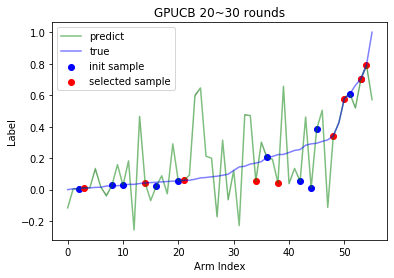

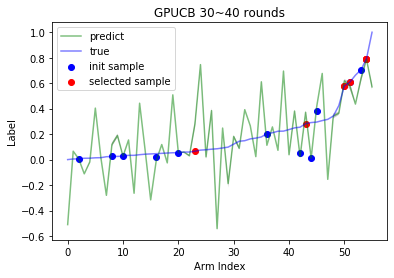

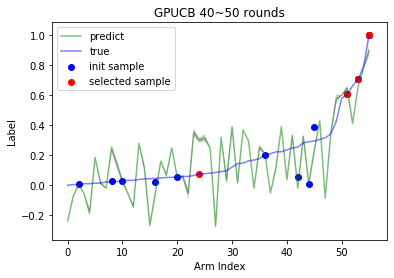

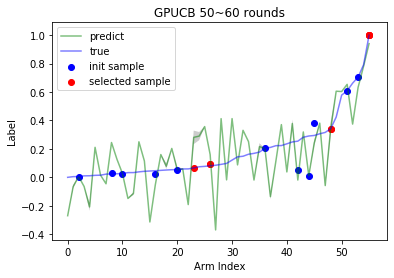

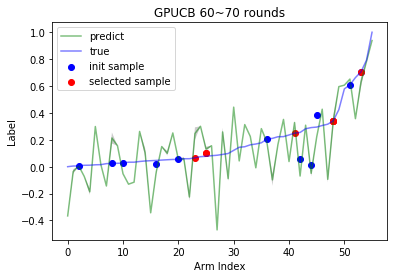

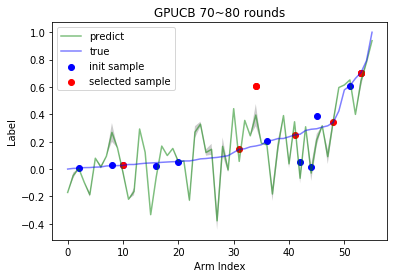

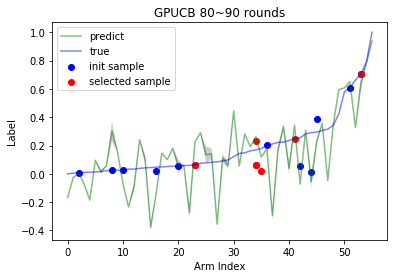

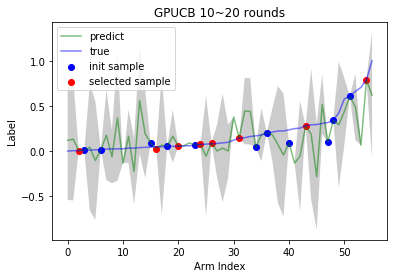

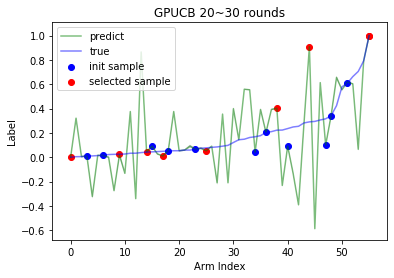

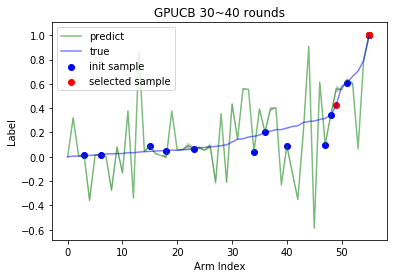

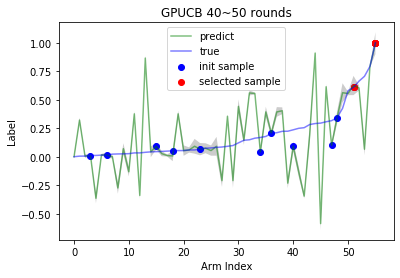

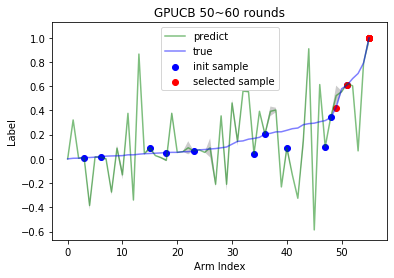

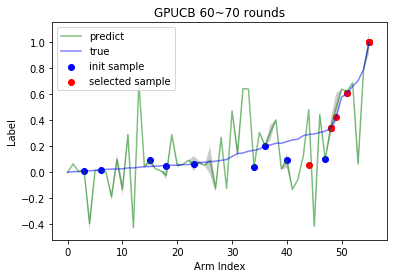

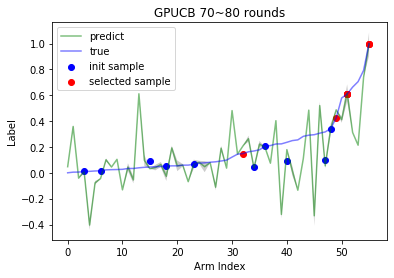

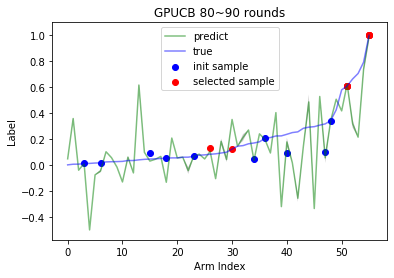

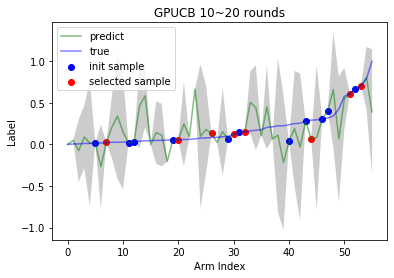

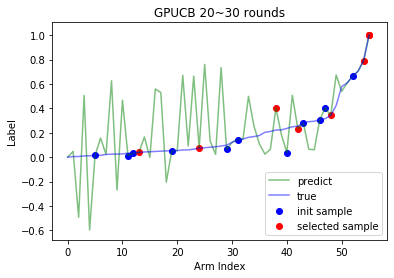

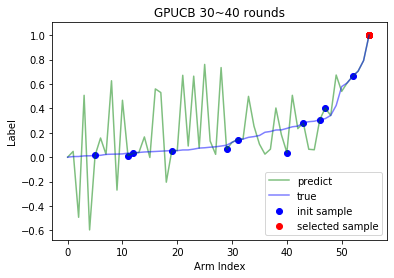

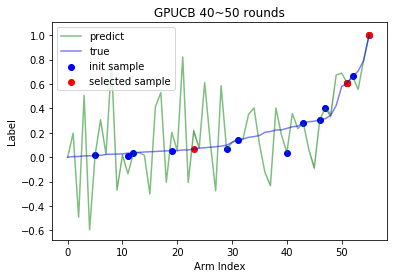

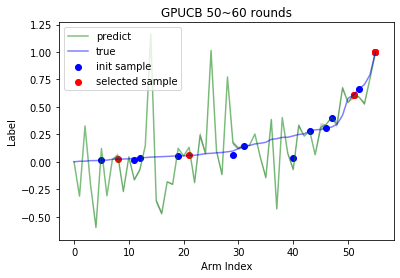

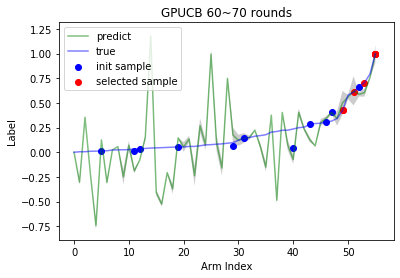

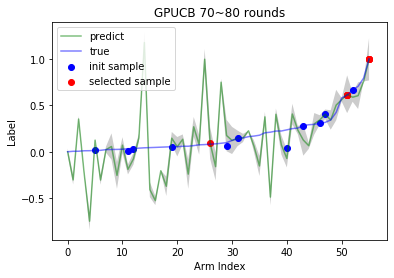

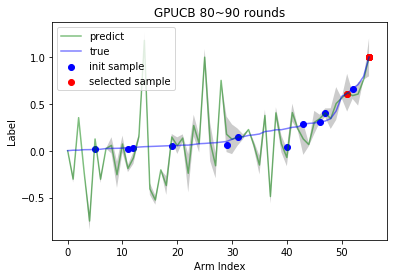

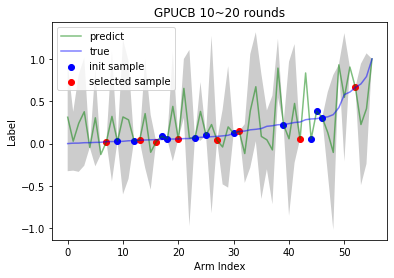

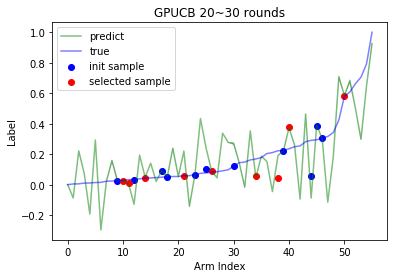

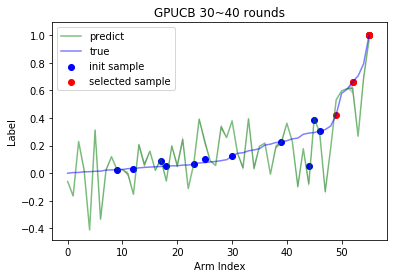

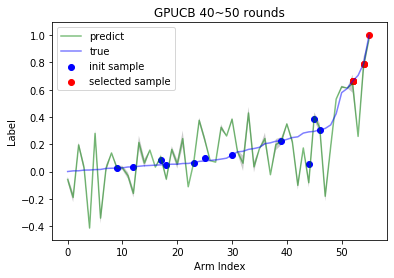

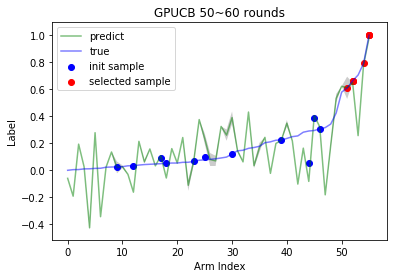

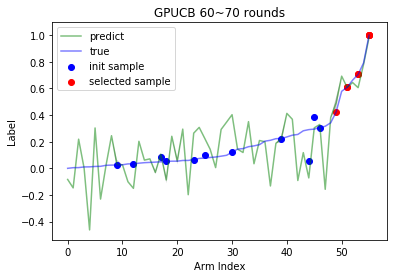

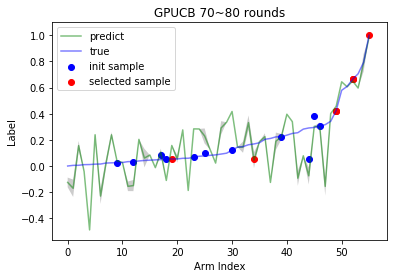

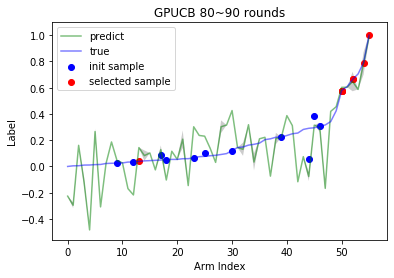

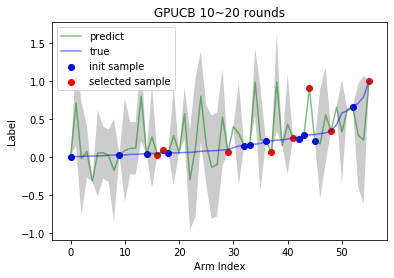

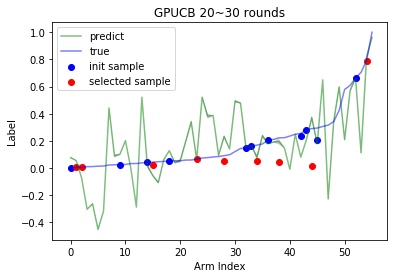

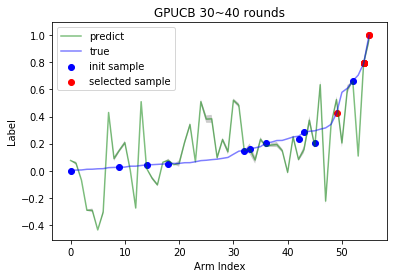

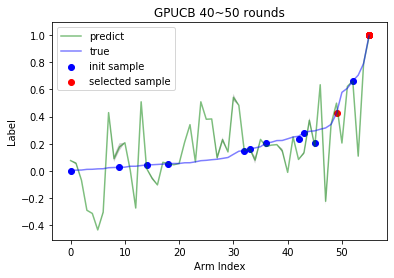

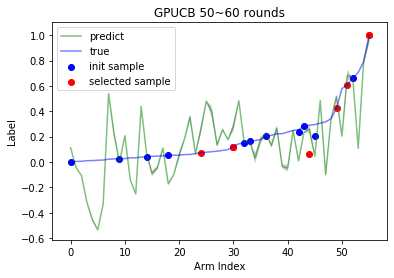

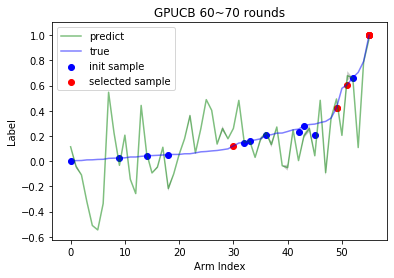

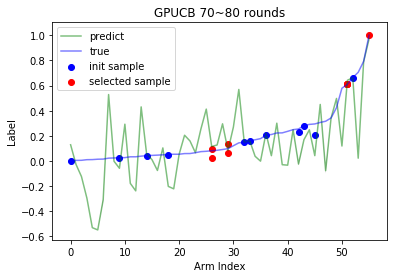

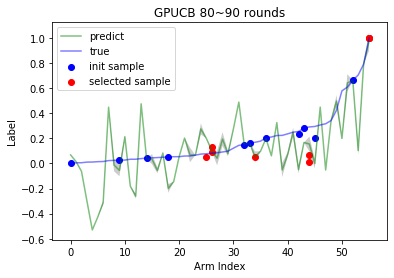

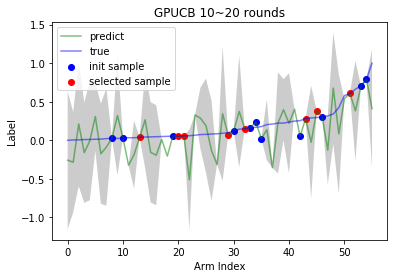

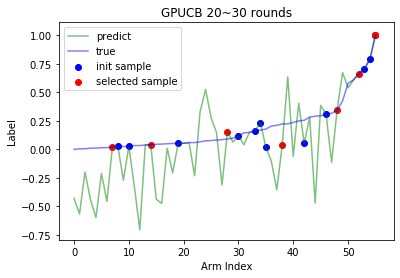

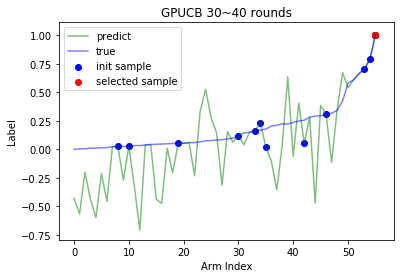

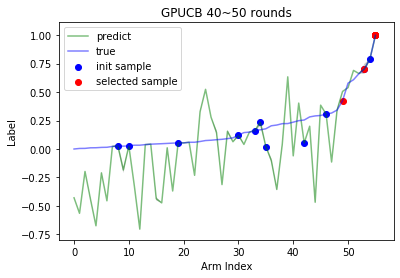

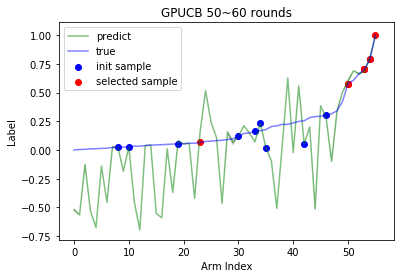

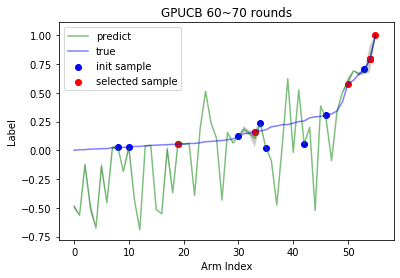

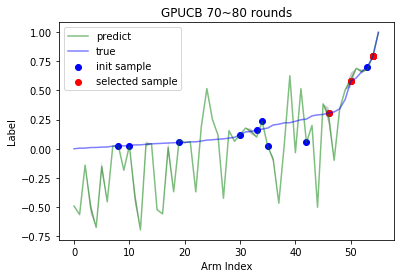

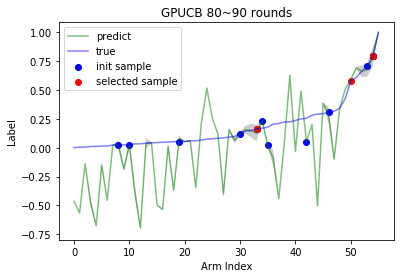

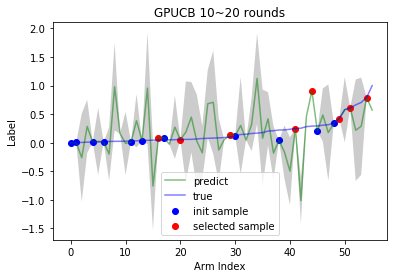

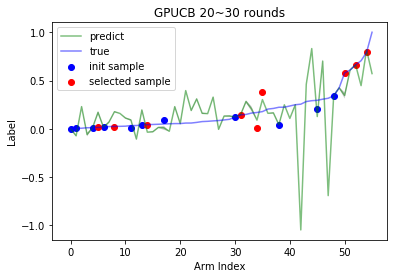

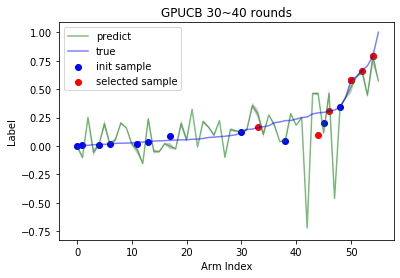

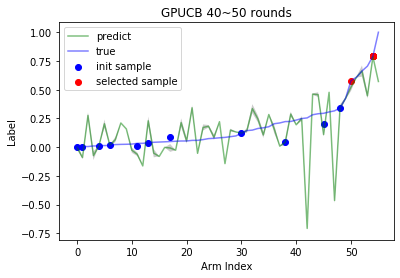

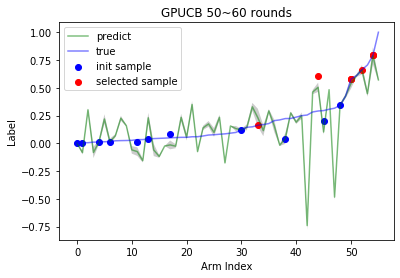

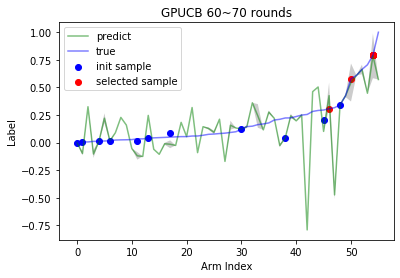

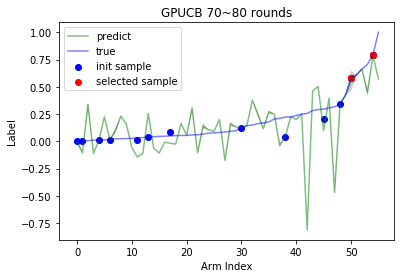

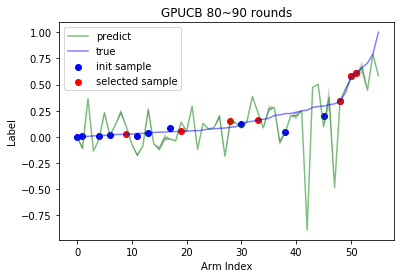

In [7]:
warnings.filterwarnings(action='ignore')

p = IntProgress(max = num_exper)
p.description = 'Running'
display(p)

models = [GPUCB, Random]
models_name = {GPUCB: 'GPUCB',
              Random: 'Random'}
models_alg = {#GPUCB: GaussianProcessRegressor(kernel = DotProduct()),
             GPUCB: GaussianProcessRegressor(kernel = PairwiseKernel(metric = spectrum_kernel_pw)),
             Random: None}

for m in models:
    for i in range(num_exper):
        p.value += 1
        agent = m(my_env, num_rounds, init_per, model = models_alg[m])
        agent.play(plot_flag = True)
        sds[models_name[m]].append(agent.suboptimalDraws)
        rs[models_name[m]].append(agent.cumulativeRegrets)

In [8]:
results = evaluate(sds, rs)

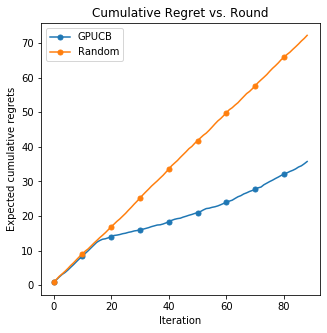

In [9]:
plot_eva(results, 'r')